In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 20 16:54:02 2019
@author: berdakh
"""
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.viz.utils import center_cmap

In [2]:
# load and preprocess data 
subject = 1  # use data from subject 1
runs = [4, 8, 12]  # use only hand and feet motor imagery runs
#        4, 8, 12   Motor imagery: left vs right hand

fnames = eegbci.load_data(subject, runs)
raws = [read_raw_edf(f, preload=True) for f in fnames]
raw = concatenate_raws(raws)

raw.rename_channels(lambda x: x.strip('.'))  # remove dots from channel names

events, _ = mne.events_from_annotations(raw, event_id=dict(T1 = 2, T2 = 3))
picks = mne.pick_channels(raw.info["ch_names"], ["C3", "Cz", "C4"])

#%% epoch data 
tmin, tmax = -1, 4  # define epochs around events (in s)
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks
event_ids = dict(left_hand=2, right_hand=3)

epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5,
                    picks=picks, baseline=None, preload=True)

[............................................................] 100.00% (  2.5 MB,   768 kB/s) |   
[............................................................] 100.00% (  2.5 MB,   1.5 MB/s) |   
[............................................................] 100.00% (  2.5 MB,   2.2 MB/s) \   
Extracting EDF parameters from /home/berdakh/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/berdakh/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/berdakh/mne_data/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.inf

In [3]:
# compute ERDS maps 
freqs = np.arange(2, 36, 1)  # frequencies from 2-35Hz
n_cycles = freqs  # use constant t/f resolution
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [-1, 0]  # baseline interval (in s)
cmap = center_cmap(plt.cm.RdBu, vmin, vmax)  # zero maps to white
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None)  # for cluster test

#%% Run TF decomposition overall epochs
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
                     use_fft=True, return_itc=False, average=False,decim=2)

tfr.crop(tmin, tmax)
tfr.apply_baseline(baseline, mode="percent")

Not setting metadata
Applying baseline correction (mode: percent)


<EpochsTFR  |  time : [-1.000000, 4.000000], freq : [2.000000, 35.000000], epochs : 45, channels : 3, ~14.1 MB>

In [4]:
%matplotlib inline 

Using a threshold of 1.717144
stat_fun(H1): min=-6.405152 max=4.276841
Running initial clustering
Found 56 clusters
Permuting 99 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.717144
stat_fun(H1): min=-6.405152 max=4.276841
Running initial clustering
Found 50 clusters
Permuting 99 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.717144
stat_fun(H1): min=-4.634662 max=3.824728
Runn

/home/berdakh/.conda/envs/mnee/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
Using a threshold of -1.720743
stat_fun(H1): min=-7.279025 max=3.531532
Running initial clustering
Found 50 clusters
Permuting 99 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Done.
No baseline correction applied
Using a threshold of 1.720743
stat_fun(H1): min=-4.099173 max=3.831260
Running initial clustering
Found 125 clusters
Permuting 99 times...
[............................................................] 100.00%  |   
Computing cluster p-values
Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations
Permuting 99 times...
[............................................................] 100.00%  |   
Computin

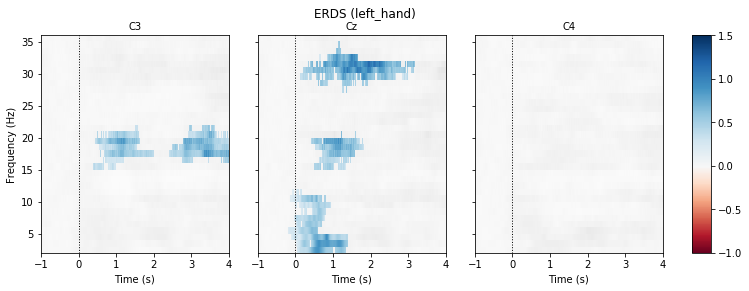

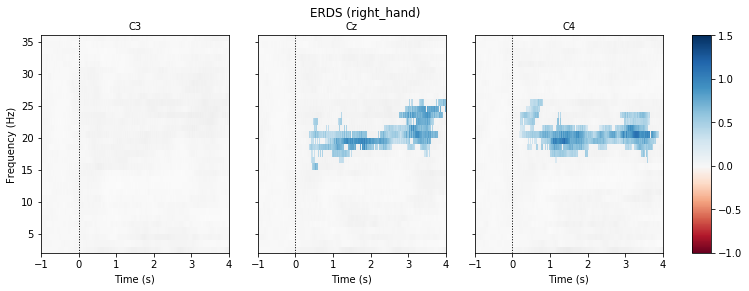

In [5]:
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch, ...], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], vmin=vmin, vmax=vmax, cmap=(cmap, False),
                              axes=ax, colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        
        if not ax.is_first_col():
            ax.set_ylabel("")
            ax.set_yticklabels("")
            
    fig.colorbar(axes[0].images[-1], cax=axes[-1])
    fig.suptitle("ERDS ({})".format(event))
    fig.show()
    fig.savefig(event+'.svg')